<b>Importing the necessary libraries</b>

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<b>Creating variables for training and validation data</b>

In [ ]:
train='/content/drive/My Drive/img_class_/seg_train/seg_train'

In [ ]:
val='/content/drive/My Drive/img_class_/seg_test/seg_test'

<b>Image Preprocessing</b>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)


#Creating generator object of training images
train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 14034 images belonging to 6 classes.


In [ ]:
val_datagen=ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

val_generator = train_datagen.flow_from_directory(val,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 3000 images belonging to 6 classes.


<b>Visualizing the images</b>

In [ ]:
labels=['Buliding','Forest','Glacier','Mountain','Sea','Street']

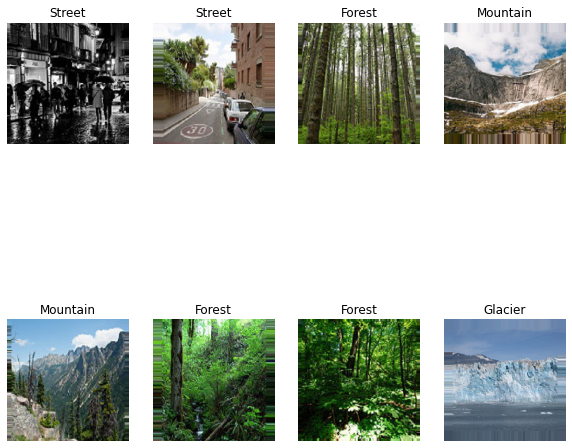

In [ ]:
import numpy as np
plt.figure(figsize=(10,10))
batch,p = train_generator.next()
for i in range(1,9):
   plt.subplot(2,4, i)
   
   image = batch[i]
   plt.imshow(image)

   #The labels are one-hot encoded, so need to find position with value 1
   plt.title(labels[np.argmax(p[i])])
   plt.axis('off')
plt.show()

<b>Creating the model</b>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions

In [ ]:
#We are using a VGG-16 model with "imagenet" weights
model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(256,256,3))

In [ ]:
#These layers will not be trained
for layers in model.layers:
  layers.trainable=False


#Taking the last layer of the VGG-16 layer
last_output = model.output


#Adding a Flatten layer
vgg_x = Flatten()(last_output)


#Adding a Dense layer for linear output
vgg_x = Dense(128, activation = 'relu')(vgg_x)


#The output layer will give 6 values, a probability distribution for each label
vgg_x = Dense(6, activation = 'softmax')(vgg_x)


#Connecting the linear layers to the VGG-16 model
vgg16_final_model = Model(model.input, vgg_x)


#Compiling the model
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])


In [ ]:
vgg16_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Fitting the model
vgg16_final_model.fit(train_generator,steps_per_epoch=len(train_generator),epochs=1,validation_data=val_generator,validation_steps=len(val_generator))

439/439 [==============================] - 9760s 22s/step - loss: 0.6952 - accuracy: 0.7597 - val_loss: 0.4941 - val_accuracy: 0.8173


In [ ]:
#Saving the model
vgg16_final_model.save('vgg_multi_classifier.h5')

In [ ]:
#Loading the model
from keras.models import load_model
vgg_m=load_model('vgg_multi_classifier.h5')

<b>Prediction</b>

In [ ]:
pred='/content/drive/My Drive/img_class_/seg_pred/seg_pred'

'Street'

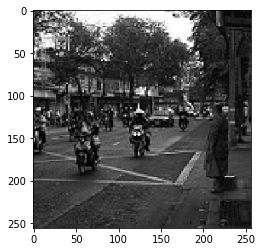

In [ ]:
from keras.preprocessing import image


#Loading the image and converting to 256*256 size 
img_pred=image.load_img(os.path.join(pred,'3.jpg'),target_size=(256,256))


#Plotting the image
plt.imshow(img_pred)


#Converting image to numpy array
img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)


#Predicting the label
rslt= vgg16_final_model.predict(img_pred)


#Showing the label
labels[np.argmax(rslt)]